In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

In [2]:
df = pd.read_csv(r"/kaggle/input/voicegender/voice.csv")
print(df.sample(5))
print(df.info())

      meanfreq        sd    median       Q25       Q75       IQR      skew  \
369   0.132855  0.084407  0.121992  0.061966  0.212941  0.150974  1.658504   
2193  0.158724  0.074530  0.159520  0.096972  0.229205  0.132234  1.112005   
458   0.171756  0.064437  0.203272  0.113661  0.223313  0.109652  2.259710   
678   0.159003  0.060683  0.148887  0.104336  0.209596  0.105260  2.383484   
1481  0.202826  0.064886  0.219751  0.168087  0.256279  0.088191  1.888726   

           kurt    sp.ent       sfm  ...  centroid   meanfun    minfun  \
369    6.382954  0.964781  0.737072  ...  0.132855  0.103769  0.016563   
2193   5.419301  0.973867  0.717529  ...  0.158724  0.145321  0.048485   
458    7.888392  0.904983  0.479155  ...  0.171756  0.113604  0.020672   
678   10.240152  0.915975  0.438488  ...  0.159003  0.100360  0.089286   
1481   6.888190  0.936807  0.585019  ...  0.202826  0.110123  0.015640   

        maxfun   meandom    mindom     maxdom    dfrange   modindx   label  
369   0.2

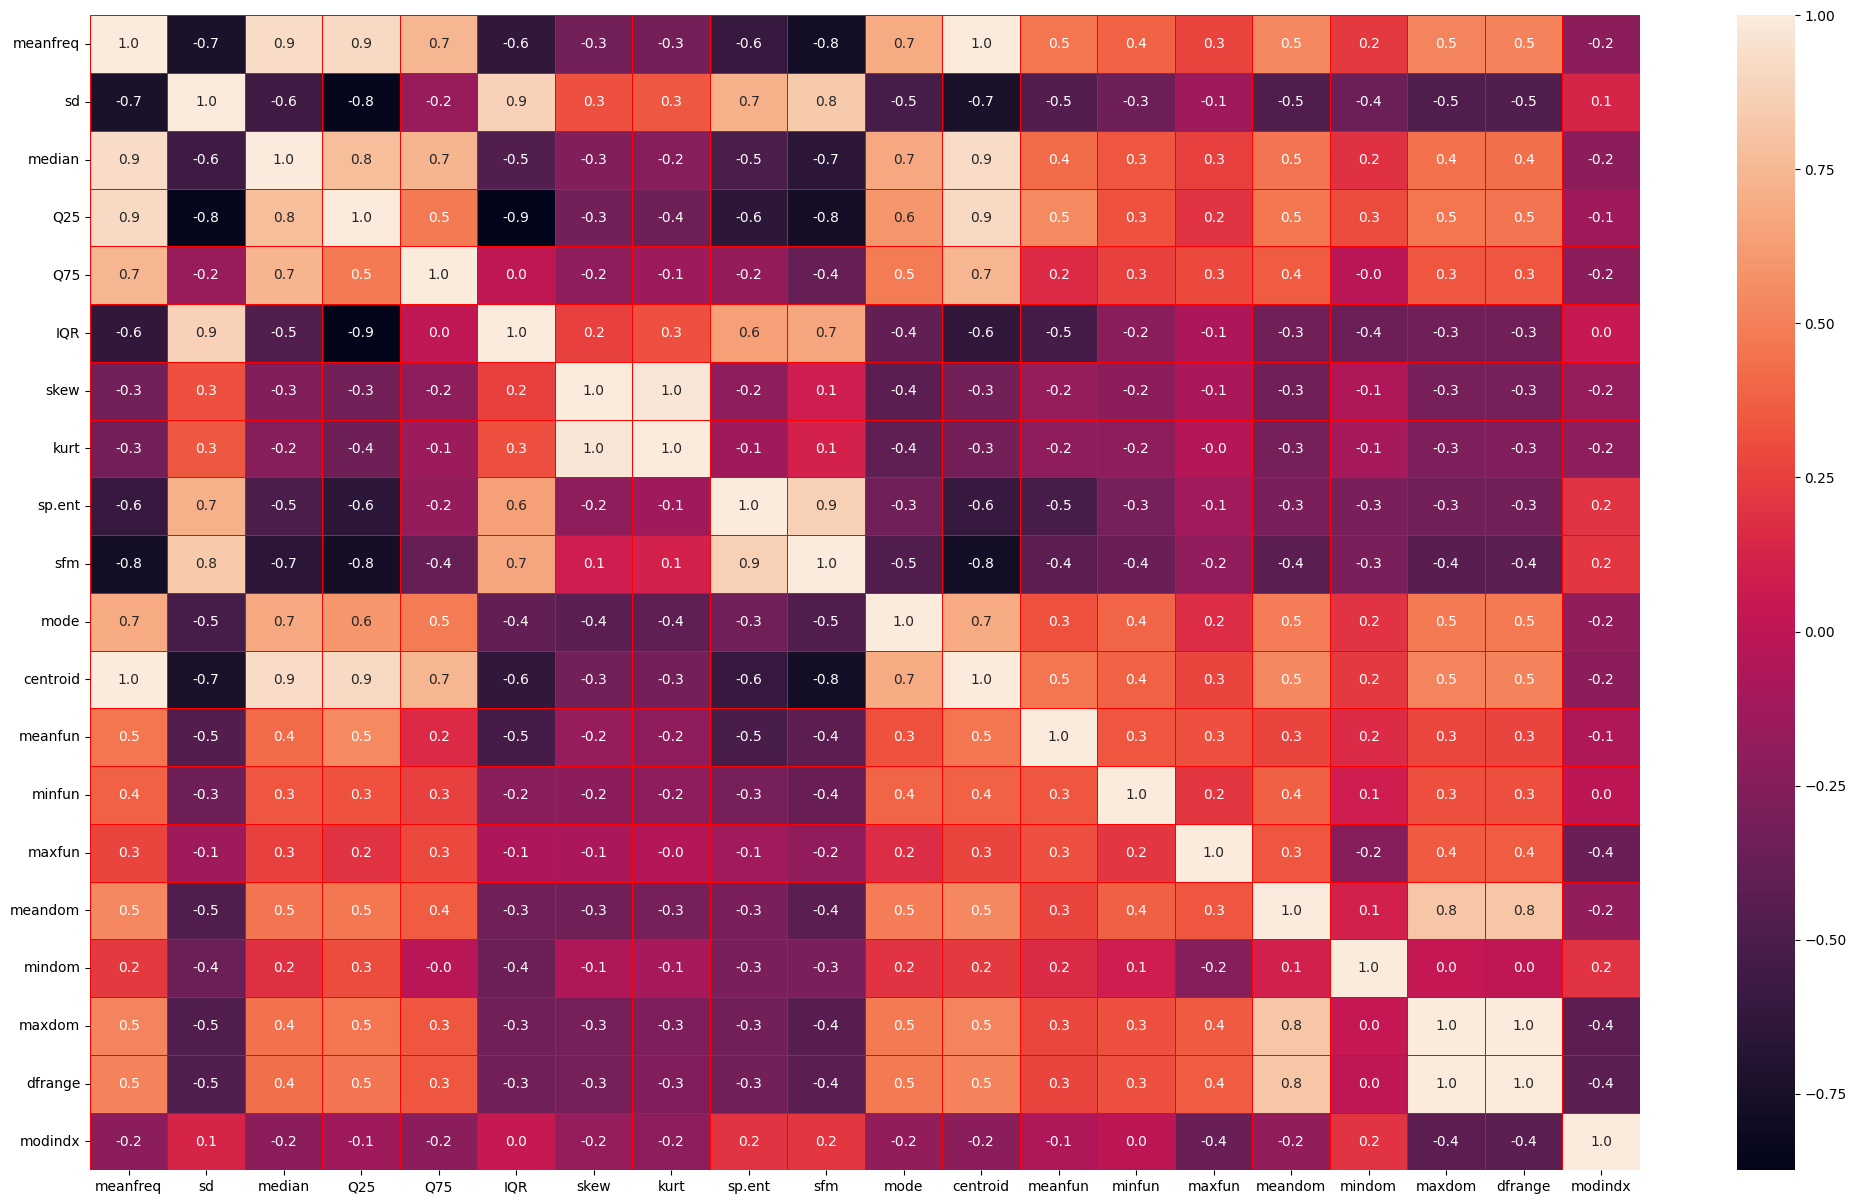

In [3]:
plt.figure(figsize=(25, 15))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, linewidths=0.5, linecolor="red", fmt='.1f')
plt.show()

In [4]:
X = df.iloc[:, :-1]
y = df['label'].apply(lambda x: 1 if x == 'male' else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
sel = SelectFromModel(RandomForestClassifier(n_estimators=100))
sel.fit(X_train, y_train)
selected_features = sel.get_support()
X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]

In [6]:
mlp = MLPClassifier(hidden_layer_sizes=(30, 30, 30), learning_rate_init=0.001)
mlp.fit(X_train_selected, y_train)
predictions = mlp.predict(X_test_selected)
print("MLP Accuracy:", accuracy_score(y_test, predictions))

MLP Accuracy: 0.9747634069400631


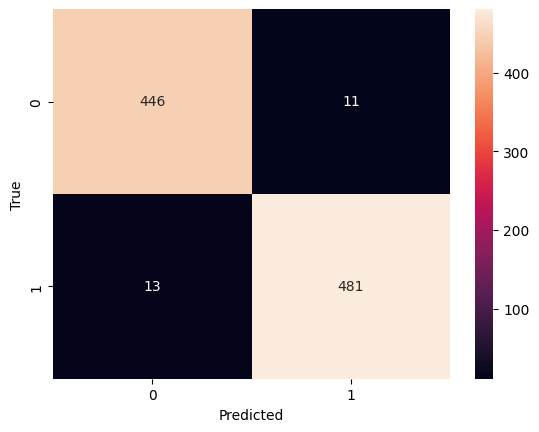

In [7]:
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [8]:
parameters = {'C': [0.1, 1, 10, 100], 'kernel': ['rbf', 'linear']}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(X_train_selected, y_train)
best_svm_pred = clf.predict(X_test_selected)
print("SVM Best Parameters:", clf.best_params_)
print("SVM Accuracy:", accuracy_score(y_test, best_svm_pred))


SVM Best Parameters: {'C': 100, 'kernel': 'rbf'}
SVM Accuracy: 0.982124079915878


In [9]:
k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']
param_dist = dict(n_neighbors=k_range, weights=weight_options)
knn = KNeighborsClassifier()
rand = RandomizedSearchCV(knn, param_dist, cv=10, n_iter=10, random_state=42)
rand.fit(X_train_selected, y_train)
print("KNN Best Score:", rand.best_score_)
print("KNN Best Parameters:", rand.best_params_)

KNN Best Score: 0.9783539195303901
KNN Best Parameters: {'weights': 'distance', 'n_neighbors': 7}


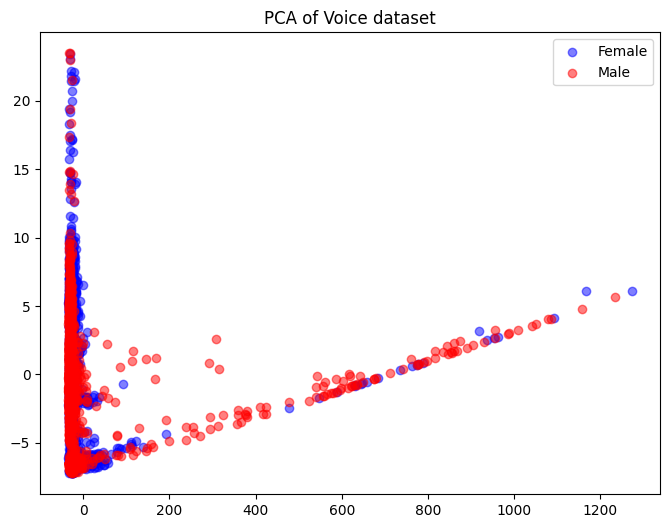

In [10]:
pca = PCA(n_components=2)
X_r = pca.fit_transform(X)
plt.figure(figsize=(8, 6))
for label, color in zip(range(2), ['blue', 'red']):
    plt.scatter(X_r[y == label, 0], X_r[y == label, 1], color=color, alpha=0.5, label=f'{"Male" if label == 1 else "Female"}')
plt.title('PCA of Voice dataset')
plt.legend()
plt.show()

In [11]:
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Update train-test split to include polynomial features
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=0)
X_train_poly = scaler.fit_transform(X_train_poly)
X_test_poly = scaler.transform(X_test_poly)

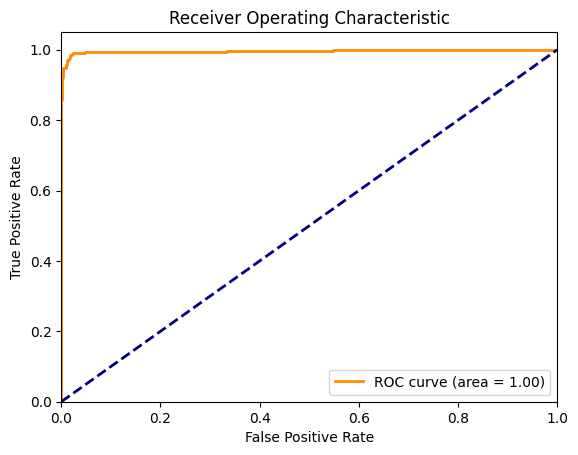

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have a fitted model, for example, the best SVM model from GridSearchCV
y_score = clf.decision_function(X_test_selected)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

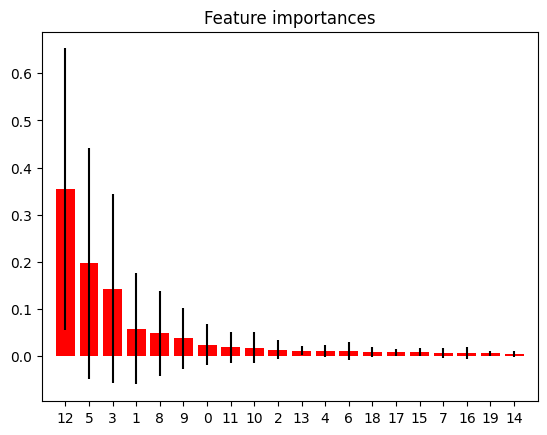

In [13]:
# Assuming RandomForestClassifier is named as `sel` from feature selection
importances = sel.estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in sel.estimator_.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Standardize the features matrix `X`
X_std = scaler.fit_transform(X)  # Assuming `X` is your original features matrix


In [15]:
from sklearn.decomposition import PCA
import plotly.express as px

# Apply PCA on the standardized features
pca = PCA(n_components=2)
components = pca.fit_transform(X_std)

# Plotting with Plotly
fig = px.scatter(components, x=0, y=1, color=df['label'].apply(lambda x: 'Male' if x == 'male' else 'Female'), labels={'0': 'Principal Component 1', '1': 'Principal Component 2'})
fig.update_layout(title='PCA of Voice Dataset', xaxis_title='Principal Component 1', yaxis_title='Principal Component 2')
fig.show()


/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


In [16]:
selected_indices = sel.get_support(indices=True)

In [17]:
def preprocess_input(raw_features, scaler, poly, selected_indices):
    # Scale the raw features
    scaled_features = scaler.transform(np.array([raw_features]))
    
    # Apply polynomial transformation
    poly_features = poly.transform(scaled_features)
    
    # Use only the selected features (align with training phase)
    final_features = poly_features[:, selected_indices]
    
    return final_features


In [18]:
# Hypothetical example of new voice sample features
voice_sample_features = [0.056, 0.082, 0.025, 0.019, 0.098, 0.087, 0.004, 0.015, 0.045, 0.072, 0.0008, 0.014, 0.00025, 0.011, 0.000085, 0.007, 0.008, 0.008, 0.0035, 0.006]

In [19]:
# Preprocess the sample with the correct selected indices
processed_sample = preprocess_input(voice_sample_features, scaler, poly, selected_indices)

# Predict with the MLP (or any other model you're using)
prediction = mlp.predict(processed_sample)

# Interpret the prediction
predicted_label = 'Male' if prediction[0] == 1 else 'Female'
print(f"Predicted label for the given voice sample is: {predicted_label}")


Predicted label for the given voice sample is: Male


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but PolynomialFeatures was fitted with feature names



In [20]:
# Hypothetical new voice sample features
new_voice_sample_features = [0.056, 0.082, 0.025, 0.019, 0.098, 0.087, 0.004, 0.015, 0.045, 0.072, 0.0008, 0.014, 0.00025, 0.011, 0.000085, 0.007, 0.008, 0.008, 0.0035, 0.006]


In [21]:
processed_new_sample = preprocess_input(new_voice_sample_features, scaler, poly, selected_indices)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but PolynomialFeatures was fitted with feature names



In [22]:
# Predict with the trained MLP classifier
prediction = mlp.predict(processed_new_sample)

# Translate the numeric prediction back to a gender label
predicted_label = 'Male' if prediction[0] == 1 else 'Female'
print(f"Predicted label for the new voice sample is: {predicted_label}")


Predicted label for the new voice sample is: Male


In [23]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=100, learning_rate=0.05)
xgb.fit(X_train_selected, y_train)

xgb_predictions = xgb.predict(X_test_selected)
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_predictions))


XGBoost Accuracy: 0.9768664563617245


In [24]:
def add_gaussian_noise(data, noise_factor=0.02):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    return augmented_data